# Inertia Gravity Wave Test Case

In [91]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS/MPAS_Ocean/"

In [92]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [93]:
mpasOcean = MPAS_Ocean(false,
                CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/InertiaGravityWaveMesh",
                "base_mesh.nc", "mesh.nc", periodicity="Periodic")
ocn_init_routines_compute_max_level!(mpasOcean)

In [94]:
function DetermineInertiaGravityWaveExactSurfaceElevation(etaHat,kX,kY,omega,x,y,time)
    eta = etaHat*cos(kX*x + kY*y - omega*time)
    return eta
end

DetermineInertiaGravityWaveExactSurfaceElevation (generic function with 1 method)

In [95]:
function DetermineInertiaGravityWaveExactZonalVelocity(etaHat,f0,g,kX,kY,omega,x,y,time)
    u = etaHat*(g/(omega^2.0 - f0^2.0)*(omega*kX*cos(kX*x + kY*y - omega*time)
                                          - f0*kY*sin(kX*x + kY*y - omega*time)))
    return u
end

DetermineInertiaGravityWaveExactZonalVelocity (generic function with 1 method)

In [96]:
function DetermineInertiaGravityWaveExactMeridionalVelocity(etaHat,f0,g,kX,kY,omega,x,y,time)
    v = etaHat*(g/(omega^2.0 - f0^2.0)*(omega*kY*cos(kX*x + kY*y - omega*time)
                                          + f0*kX*sin(kX*x + kY*y - omega*time)))
    return v
end

DetermineInertiaGravityWaveExactMeridionalVelocity (generic function with 1 method)

mpasOcean.fEdge .= 0.0000351

In [97]:
meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)

0.0010000000000000007

mpasOcean.bottomDepth .= 878.2

In [98]:
meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)

1000.0

In [99]:
gravity = mpasOcean.gravity

9.8


$ \pmatrix{\eta\\ u\\ v } = Real( \pmatrix{A\\ U\\ V} e^{i ( k_x x + k_y y - \omega t) } ) $

$ \frac{\partial \eta}{\partial t} = Real(- i w A e^{i ( k_x x + k_y y - \omega t) }) $

$ \frac{\partial u}{\partial x} = Real(i k_x U e^{i ( k_x x + k_y y - \omega t) }) $

$ \frac{\partial v}{\partial y} = Real(i k_y V e^{i ( k_x x + k_y y - \omega t) }) $

$ \frac{\partial \eta}{\partial t} = - \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y} $

$ Real(- i w A e^{i ( k_x x + k_y y - \omega t) }) = - Real(i k_x U e^{i ( k_x x + k_y y - \omega t) } + i k_y V e^{i ( k_x x + k_y y - \omega t) }) $

In [100]:
kx = 1 * 2*pi / mpasOcean.lX
# U = 2.0e-3

ky = 1  * 2*pi / mpasOcean.lY
# V = 4.5e-4

k = sqrt(kx^2 + ky^2)

w = sqrt(meanCoriolisParameterf^2 + gravity*meanFluidThicknessH*k^2)
A = 0.1
# A = (kx*U + ky*V) / w

kx, ky, w, A

(6.283185307179586e-7, 7.255197456936872e-7, 0.001004503558061824, 0.1)

In [101]:
gravity = mpasOcean.gravity

9.8

In [102]:
maximum(mpasOcean.angleEdge)

5.235987755982989

In [103]:
function inertiaGravityInit!(mpasOcean, t=0; kx=kx, ky=ky, w=w, A=A)
    for iCell in 1:mpasOcean.nCells
        x = mpasOcean.xCell[iCell]
        y = mpasOcean.yCell[iCell]
        
        mpasOcean.sshCurrent[iCell] = DetermineInertiaGravityWaveExactSurfaceElevation(A, kx, ky, w, x, y, t)
    end
    
    for iEdge in 1:mpasOcean.nEdges
        x = mpasOcean.xEdge[iEdge]
        y = mpasOcean.yEdge[iEdge]
        
#         u = U*cos(kx*x + ky*y - w*t)
        u = DetermineInertiaGravityWaveExactZonalVelocity(A, meanCoriolisParameterf, gravity, kx, ky, w, x, y, t)
        
#         v = V*cos(kx*x + ky*y - w*t)
        v = DetermineInertiaGravityWaveExactMeridionalVelocity(A, meanCoriolisParameterf, gravity, kx, ky, w, x, y, t)
        
        theta = mpasOcean.angleEdge[iEdge]
        
        mpasOcean.normalVelocityCurrent[iEdge] = u*cos(theta) + v*sin(theta)
    end
end

inertiaGravityInit! (generic function with 2 methods)

In [104]:
inertiaGravityInit!(mpasOcean)

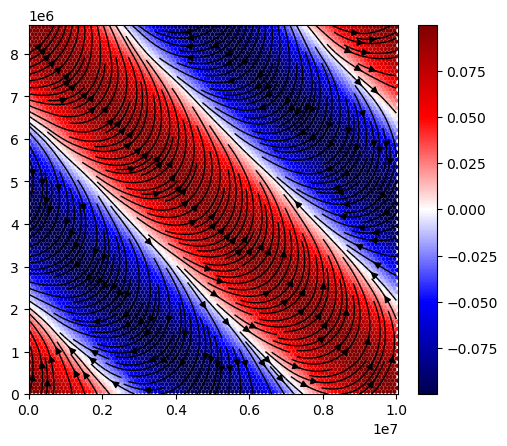

In [105]:
fig, ax, cbar, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
vectorStreamPlotMesh(mpasOcean, mpasOcean.normalVelocityCurrent, fig=fig, ax=ax, cbar=cbar, xbins=17, ybins=13)
display(fig)

# Simulate wave

In [106]:
const dt_orig = 101

101

In [107]:
mpasOcean.dt = 20

20

In [108]:
2*pi/(w*mpasOcean.dt) # number of timesteps per cycle of wave

312.7507740889891

In [109]:
nFrames = 50

steps = 3

sshOverTime = zeros(Float64, (nFrames, mpasOcean.nCells))
normalVelocityOverTime = zeros(Float64, (nFrames, mpasOcean.nEdges))

for i in 1:nFrames
    for j in 1:steps
        forward_backward_step!(mpasOcean)
    end
    sshOverTime[i,:] .= mpasOcean.sshCurrent[:]
    normalVelocityOverTime[i,:] .= mpasOcean.normalVelocityCurrent[:]
end

## animate simulation

In [110]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fa842eccaf0>

In [111]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [75]:
c = sqrt(mpasOcean.gravity*meanFluidThicknessH)

98.99494936611666

In [76]:
mpasOcean.dt

20.0

In [77]:
mpasOcean.dcEdge[1]

100000.0

In [78]:
mpasOcean.dcEdge[1]/c / mpasOcean.dt

50.507627227610534

In [79]:
1/ans

0.019798989873223333

In [80]:
w/k

1046.6059958043525

In [81]:
cx = w/kx
cy = w/ky

1384.5295927837135

In [82]:
dx = mpasOcean.dcEdge[1]
dy = dx * sqrt(3)/2

86602.54037844385

In [83]:
mpasOcean.dt

20.0

In [84]:
mpasOcean.dt = 20

20

In [85]:
mpasOcean.dt*(cx/dx + cy/dy)

0.6394868264757438

# Exact solution

In [112]:
sshOverTimeExact = zeros(Float64, (nFrames, mpasOcean.nCells))
normalVelocityOverTimeExact = zeros(Float64, (nFrames, mpasOcean.nEdges))

t = 0

for i in 1:nFrames
    t += steps*mpasOcean.dt
    inertiaGravityInit!(mpasOcean, t)
    sshOverTimeExact[i,:] .= mpasOcean.sshCurrent[:]
    normalVelocityOverTimeExact[i,:] .= mpasOcean.normalVelocityCurrent[:]
end

In [113]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fa842647130>

In [114]:
maximum(sshOverTimeExact)

0.09999999817298634

In [115]:
maximum(sshOverTime)

0.10695360119019567

In [116]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

## animate difference

In [117]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:]-sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:]-sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fa83fff5c10>

In [118]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# animating normal velocities

In [78]:
fig, ax, cbar = vectorStreamPlotMesh(mpasOcean, normalVelocityOverTimeExact[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
#     col.set_array(sshOverTime[i+1,:])
    ax.clear()
    vectorStreamPlotMesh(mpasOcean, normalVelocityOverTimeExact[i+1,:], fig=fig, ax=ax, cbar=cbar)
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f92c6edb100>

In [79]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [80]:
fig, ax, cbar = vectorStreamPlotMesh(mpasOcean, normalVelocityOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
#     col.set_array(sshOverTime[i+1,:])
    ax.clear()
    vectorStreamPlotMesh(mpasOcean, normalVelocityOverTime[i+1,:], fig=fig, ax=ax, cbar=cbar)
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f92c2a6cf70>

In [81]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [82]:
U = normalVelocityOverTime .* cos.(mpasOcean.angleEdge)'

arr = diff(U, dims=1) #diff(normalVelocityOverTime, dims=1)

cMax = maximum(abs.(arr))

fig, ax, cbar, col = edgeHeatMapMesh(mpasOcean, arr[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
#     col.set_array(arr[i+1,:])
    ax.clear()
    edgeHeatMapMesh(mpasOcean, arr[i+1,:], cMin=-cMax, cMax=cMax, fig=fig, ax=ax, cbar=cbar)
    
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames-1)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f92cc1f5700>

In [83]:
ipydisplay.HTML(anim.to_html5_video())
# display(fig)

LoadError: InterruptException:

In [84]:
U = normalVelocityOverTimeExact .* cos.(mpasOcean.angleEdge)'

arr = diff(U, dims=1) #diff(normalVelocityOverTime, dims=1)

cMax = maximum(abs.(arr))

fig, ax, _, col = edgeHeatMapMesh(mpasOcean, arr[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
#     col.set_array(arr[i+1,:])
    ax.clear()
    edgeHeatMapMesh(mpasOcean, arr[i+1,:], cMin=-cMax, cMax=cMax, fig=fig, ax=ax, cbar=cbar)
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames-1)

LoadError: InterruptException:

In [85]:
ipydisplay.HTML(anim.to_html5_video())
# display(fig)

PyObject <IPython.core.display.HTML object>